# Setup

In [1]:
# import all required packages
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

In [4]:
processed_data_path = '/content/drive/MyDrive/Folsom_sky_images/processed_data.csv'
irradiance_data = pd.read_csv(processed_data_path)
irradiance_data.head()

,timeStamp,ghi,Year,Month,Day,Hour,Minute,dwsw,cloud_cover,precipitation,...,ENT(G),AVG(B),STD(B),ENT(B),AVG(RB),STD(RB),ENT(RB),AVG(NRB),STD(NRB),ENT(NRB)
0,2014-01-02 08:00:00,0.0,2014.0,1.0,2.0,8.0,0.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
1,2014-01-02 08:01:00,0.0,2014.0,1.0,2.0,8.0,1.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
2,2014-01-02 08:02:00,0.0,2014.0,1.0,2.0,8.0,2.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
3,2014-01-02 08:03:00,0.0,2014.0,1.0,2.0,8.0,3.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
4,2014-01-02 08:04:00,0.0,2014.0,1.0,2.0,8.0,4.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882


In [5]:
irradiance_data.shape

(1551888, 34)

In [6]:
irradiance_data.columns

Index(['timeStamp', 'ghi', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'dwsw',
       'cloud_cover', 'precipitation', 'pressure', 'wind-u', 'wind-v',
       'temperature', 'rel_humidity', 'cloud_cover_ratio',
       'satellite_image_AVG', 'satellite_image_STD', 'satellite_image_ENT',
       'AVG(R)', 'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)',
       'STD(B)', 'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)',
       'STD(NRB)', 'ENT(NRB)'],
      dtype='object')

# Split Data into Training and Testing Sets

In [7]:
column_indices = {name: i for i, name in enumerate(irradiance_data.columns)}

irradiance_data = irradiance_data.drop(["timeStamp"],axis=1)

train_df = irradiance_data[irradiance_data.Year <= 2015]
test_df = irradiance_data[irradiance_data.Year == 2016]

X_train = train_df.drop(["Year","ghi"],axis=1)
Y_train = pd.DataFrame(train_df.loc[:,"ghi"])

X_test = test_df.drop(["Year","ghi"],axis=1)
Y_test = pd.DataFrame(test_df.loc[:,"ghi"])

In [8]:
X_train.columns

Index(['Month', 'Day', 'Hour', 'Minute', 'dwsw', 'cloud_cover',
       'precipitation', 'pressure', 'wind-u', 'wind-v', 'temperature',
       'rel_humidity', 'cloud_cover_ratio', 'satellite_image_AVG',
       'satellite_image_STD', 'satellite_image_ENT', 'AVG(R)', 'STD(R)',
       'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)', 'STD(B)', 'ENT(B)',
       'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)', 'STD(NRB)', 'ENT(NRB)'],
      dtype='object')

In [9]:
X_train.shape

(1029600, 31)

# Normalize the data

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaler = scaler.fit_transform(X_train.values)
X_test_scaler = scaler.transform(X_test.values)

# Data Lags
forecast irradiance (GHI) with 30 minute horizon and one minute granularity (IE, predicting t+1, t+2, t+3…, t+30).

# Model Evaluation

In [11]:
trainX = np.reshape(X_train_scaler, (X_train_scaler.shape[0], 1, X_train_scaler.shape[1]))
testX = np.reshape(X_test_scaler, (X_test_scaler.shape[0], 1, X_test_scaler.shape[1]))

In [12]:
!pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=bab8f0a45972f74d4514fd7791e88383b39652dc7224c0e56cde1adde1fe5a76
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420178 sha256=e2f41449f6b10cdb87bce071a3e3b1c2e9119cc5e277999e5bb44262295b6164
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102544 sha256=3edda5be0bed59009b2b750162

# Load Best Performed Model: LSTM model with Early Stopping, Reduce Learning Rate, Dropout and Regularization

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from GPyOpt.methods import BayesianOptimization
from keras import backend as K

# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [16]:
LSTM_model = tf.keras.models.load_model('/content/LSTM_ES_RLR_DP_Reg_model.h5', custom_objects={'root_mean_squared_error':
root_mean_squared_error})

In [17]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               81920     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 90241 (352.50 KB)
Trainable params: 90241 (352.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
yhat = LSTM_model.predict(testX)
yhat

16322/16322 [==============================] - 38s 2ms/step


array([[-0.9108343],
       [-0.9510045],
       [-0.9520521],
       ...,
       [ 1.8599486],
       [ 2.134564 ],
       [ 2.1431305]], dtype=float32)

In [19]:
# model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

print("Model Evaluation scores:")

# calculate RMSE
testrmse = root_mean_squared_error(Y_test, yhat)

print('Test RMSE: %.3f' % testrmse)
# calculate Rsqured
r2=r2_score(Y_test, yhat)
print('Test R2: %.3f' % r2)

# calculate mse
mse = mean_squared_error(Y_test, yhat)
print('Test MSE: %.3f' % mse)

# mean absolute error
mae = mean_absolute_error(Y_test, yhat)
print('Test MAE: %.3f' % mae)

Model Evaluation scores:
Test RMSE: 74.192
Test R2: 0.936
Test MSE: 5504.393
Test MAE: 35.157


# Plot Solar Irradiance

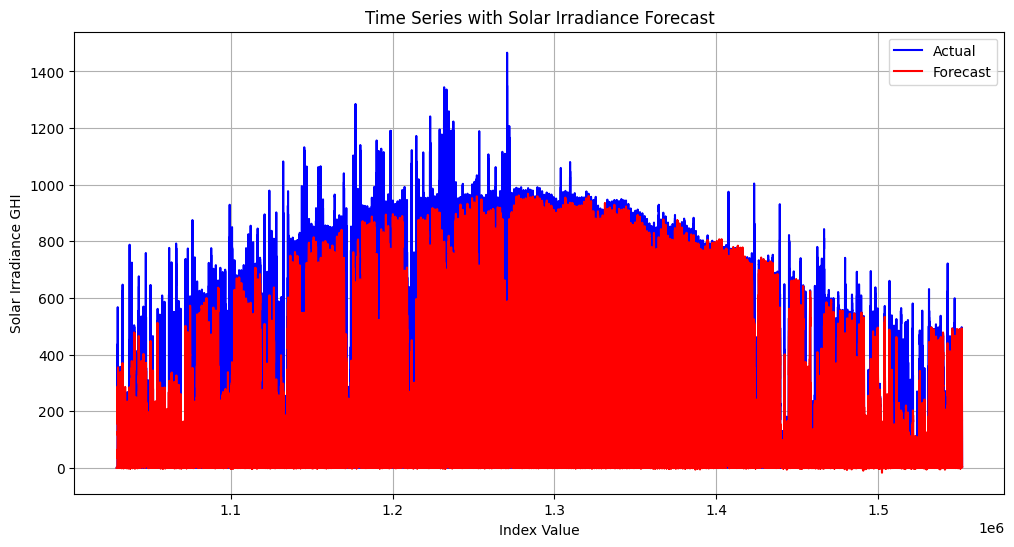

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the time series data and forecast
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, Y_test, label='Actual', color='blue')
plt.plot(test_df.index, yhat, label='Forecast', color='red')

# Add labels and title
plt.xlabel('Index Value')
plt.ylabel('Solar Irradiance GHI')
plt.title('Time Series with Solar Irradiance Forecast')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# Autoregressive LSTM RNN model

In [22]:
All_RMSE = []
forecast_horizon = []
horizon = 30

for kt in range(horizon):
  print("Time Step:", kt)
  forecast_horizon.append(kt)
  lag_df = test_df.shift(-kt)
  lag_df = lag_df.dropna()

  X_lag = lag_df.drop(["Year","ghi"],axis=1)
  Y_lag = pd.DataFrame(lag_df.loc[:,"ghi"])

  X_lag_scaler = scaler.transform(X_lag.values)

  lagX = np.reshape(X_lag_scaler, (X_lag_scaler.shape[0], 1, X_lag_scaler.shape[1]))

  yhat_lag = LSTM_model.predict(lagX)

  # calculate RMSE
  rmse = np.sqrt(mean_squared_error(Y_test[kt:], yhat_lag))
  All_RMSE.append(rmse)



Time Step: 0
16322/16322 [==============================] - 36s 2ms/step
Time Step: 1
16322/16322 [==============================] - 36s 2ms/step
Time Step: 2
16322/16322 [==============================] - 36s 2ms/step
Time Step: 3
16322/16322 [==============================] - 36s 2ms/step
Time Step: 4
16322/16322 [==============================] - 37s 2ms/step
Time Step: 5
16322/16322 [==============================] - 36s 2ms/step
Time Step: 6
16322/16322 [==============================] - 37s 2ms/step
Time Step: 7
16322/16322 [==============================] - 37s 2ms/step
Time Step: 8
16322/16322 [==============================] - 37s 2ms/step
Time Step: 9
16322/16322 [==============================] - 37s 2ms/step
Time Step: 10
16322/16322 [==============================] - 38s 2ms/step
Time Step: 11
16322/16322 [==============================] - 36s 2ms/step
Time Step: 12
16322/16322 [==============================] - 36s 2ms/step
Time Step: 13
16322/16322 [=====================

In [23]:
All_RMSE

[74.19159730380963,
 74.19166833130168,
 74.19173934075108,
 74.19181035174913,
 74.19188137873061,
 74.19195240750312,
 74.19202341732674,
 74.19209441058165,
 74.19216544044569,
 74.19223646953127,
 74.19230747716873,
 74.19237849183241,
 74.19244951250054,
 74.19252053232333,
 74.19259153221066,
 74.19266254173831,
 74.19273354961557,
 74.19280457166852,
 74.19287560247524,
 74.19294661774623,
 74.19301763474779,
 74.19308865209402,
 74.19315965557261,
 74.1932306753618,
 74.19330170235187,
 74.19337272990519,
 74.19344376240562,
 74.1935147780859,
 74.19358578957521,
 74.19365680821906]

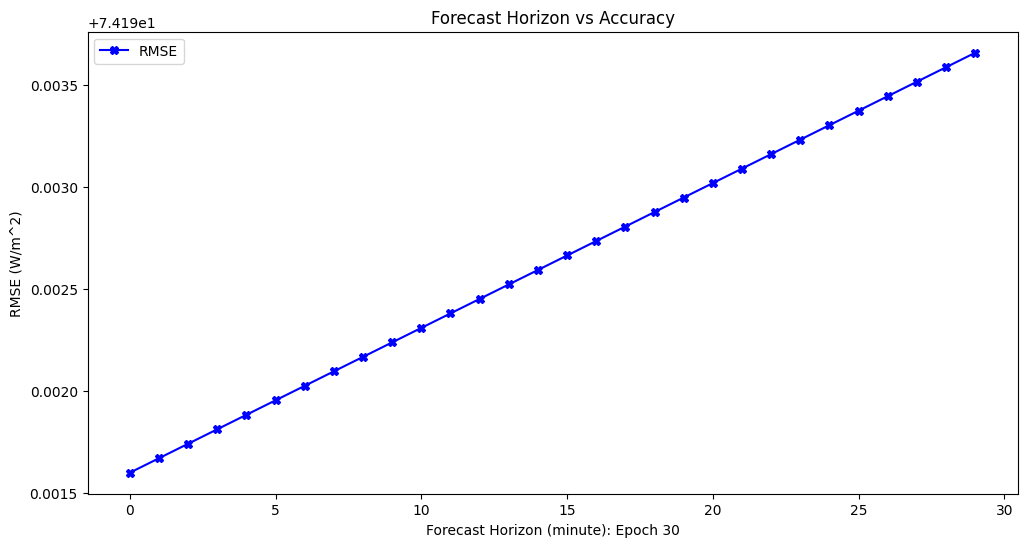

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the time series data and forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_horizon, All_RMSE, label='RMSE', color='blue', marker='X')

# Add labels and title
plt.xlabel('Forecast Horizon (minute): Epoch 30')
plt.ylabel('RMSE (W/m^2)')
plt.title('Forecast Horizon vs Accuracy')

# Add a legend
plt.legend()

# Display the plot
plt.show()